In [1]:
import sys
sys.path

['/eos/home-i01/a/antoniov/SWAN_projects/opendata',
 '/cvmfs/sft.cern.ch/lcg/releases/condor/24.0.7-acbb2/x86_64-el9-gcc13-opt/lib/python3',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/itk',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/python',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib',
 '',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages',
 '/usr/local/lib/swan/nb_term_lib',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python311.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/lib-dynload',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/site-packages',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/

In [2]:
import matplotlib.pyplot as plt
import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak
import coffea
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)
print ( ak.__version__ )
print ( coffea.__version__ )
print ( dask.__version__ )
print ( hist.__version__ )

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


2.6.7
2025.1.0
2024.9.0
2.8.0


In [3]:
# help(LocalCluster)

In [4]:
from dask.distributed import Client
client = Client()
# from dask.distributed import LocalCluster
# LocalCluster(n_workers=4, threads_per_worker=1, processes=True, memory_limit="2GiB")
# client = cluster.get_client()

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40153,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:45895,Total threads: 1
Dashboard: http://127.0.0.1:37411/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:43031,


In [6]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        # muons = ak.zip(
        #     {
        #         "pt": events.Muon_pt,
        #         "eta": events.Muon_eta,
        #         "phi": events.Muon_phi,
        #         "mass": events.Muon_mass,
        #         "charge": events.Muon_charge,
        #     },
        #     with_name="PtEtaPhiMCandidate",
        #     behavior=candidate.behavior,
        # )
        muons = events.Muon

        h_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{\mu\mu}$ [GeV]")
            .Int64()
        )

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="same", mass=dimuon.mass)

        return {
            dataset: {
                "entries": ak.num(events, axis=0),
                "mass": h_mass,
            }
        }

    def postprocess(self, accumulator):
        pass

In [7]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# fname = "https://raw.githubusercontent.com/scikit-hep/coffea/master/tests/samples/nano_dy.root"
filename = "root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/127C2975-1B1C-A046-AABF-62B77E757A86.root"
nanofactory = NanoEventsFactory.from_root(
    {filename: "Events"},
    schemaclass=NanoAODSchema,
    # metadata={"dataset": "DYJets"},
    metadata={"dataset": "DoubleMuon"},
)
nanofactory

In [8]:
events = nanofactory.events()
events

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


dask.awkward<from-uproot, npartitions=1>

In [9]:
events.Muon.pt?

Type:            Array
String form:     dask.awkward<pt, npartitions=1>
File:            /cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/dask_awkward/lib/core.py
Docstring:       pt
Class docstring:
Partitioned, lazy, and parallel Awkward Array Dask collection.

The class constructor is not intended for users. Instead use
factory functions like :py:func:`~dask_awkward.from_parquet`,
:py:func:`~dask_awkward.from_json`, etc.

Within dask-awkward the ``new_array_object`` factory function is
used for creating new instances.


In [10]:
help(events.Muon)

Help on Array in module dask_awkward.lib.core:

dask.awkward<Muon, npartitions=1>
    slimmedMuons after basic selection (pt > 15 || (pt > 3 && (passed('CutBasedIdLoose') || passed('SoftCutBasedId') || passed('SoftMvaId') || passed('CutBasedIdGlobalHighPt') || passed('CutBasedIdTrkHighPt'))))



In [11]:
proc = Processor()
coll = proc.process(events)
(out,) = dask.compute(coll)
out

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


{'DoubleMuon': {'entries': 2147195,
  'mass': Hist(
    StrCategory(['opposite', 'same'], name='sign'),
    Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Int64()) # Sum: 1121852.0 (1124805.0 with flow)}}

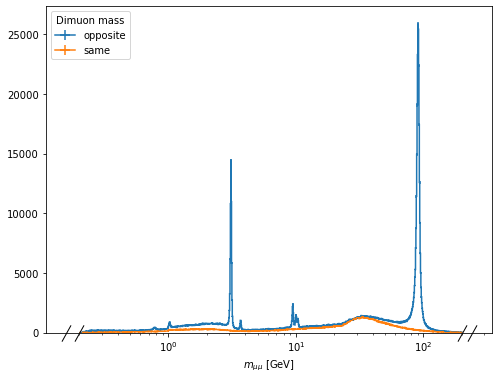

In [12]:
fig, ax = plt.subplots( figsize=(8,6) )
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon mass")

In [13]:
fileset = {
    'DoubleMuon': {
        "files": {
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/127C2975-1B1C-A046-AABF-62B77E757A86.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/183BFB78-7B5E-734F-BBF5-174A73020F89.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/790F8A75-8256-3B46-8209-850DE0BE3C77.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/7F53D1DE-439E-AD48-871E-D3458DABA798.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/8A696857-C147-B04A-905A-F85FB76EDA23.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/8B253755-51F2-CB49-A4B6-C79637CAE23F.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/9528EA75-1C0B-9047-A9A3-6A47564F7A98.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/A6605227-0B58-864E-8422-B8990D18F622.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/B2DC29E0-8679-1D4F-A5AE-E7D0284A20D4.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/B450B2B3-BEF8-8C43-82BF-7AD0EF2EA7EA.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/B7AA7F04-5D5F-514A-83A6-9A275198852C.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/B93B57BF-4239-A049-9531-4C542C370185.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/1BE226A3-7A8D-1B43-AADC-201B563F3319.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/C4558F81-9F2C-1349-B528-6B9DD6838D6D.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/C8CFC890-D4B8-8A4F-8699-C6ACCDF1620A.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/CAA285FF-7A12-F945-9183-DC7042178535.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/CD267D88-E57D-3B44-AC45-0712E2E12B87.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/E7C51551-7A75-5C41-B468-46FB922F36A9.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/EBC200F4-C06F-CE45-BAAA-7CAECDD3076F.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/EEB2FE3F-7CF3-BF4A-9F70-3F89FACE698E.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/F5E234F9-1E9C-0042-B395-AB6407E4A336.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/1DE780E2-BCC2-DC48-815D-9A97B2A4A2CD.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/21DA4CE5-4E50-024F-9CE1-50C77254DD4E.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/2C6A0345-8E2E-9B41-BB51-DB56DFDFB89A.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/3676E287-A650-8F44-BBCB-3B8556966406.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/411A019C-7058-FD42-AD50-DE74433E6859.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/46A8960A-E58F-4648-9C12-2708FE7C12FB.root': 'Events',
            'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/2510000/4F0B53A7-6440-924B-AF48-B5B61D3CE23F.root': 'Events'
        }
    }
}

dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [14]:
to_compute = apply_to_fileset(
                Processor(),
                max_chunks(dataset_runnable, 300),
                schemaclass=NanoAODSchema,
            )
(out,) = dask.compute(to_compute)
print(out)

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


{'DoubleMuon': {'DoubleMuon': {'entries': 48912812, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 25768212.0 (25831685.0 with flow)}}}


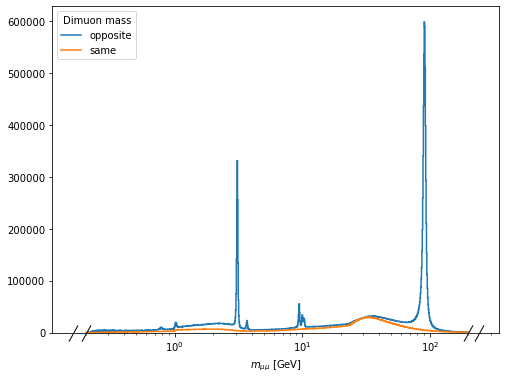

In [15]:
fig, ax = plt.subplots( figsize=(8,6) )
out["DoubleMuon"]["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon mass")